In [ ]:
import librosa as lb
import matplotlib
import numpy as np

In [ ]:
path = '/content/Crazy.wav'

In [ ]:
y, sr = lb.load(path, sr = None)

In [ ]:
short_time = lb.stft(y)  # STFT of y
S_db = lb.amplitude_to_db(np.abs(short_time), ref=np.max)

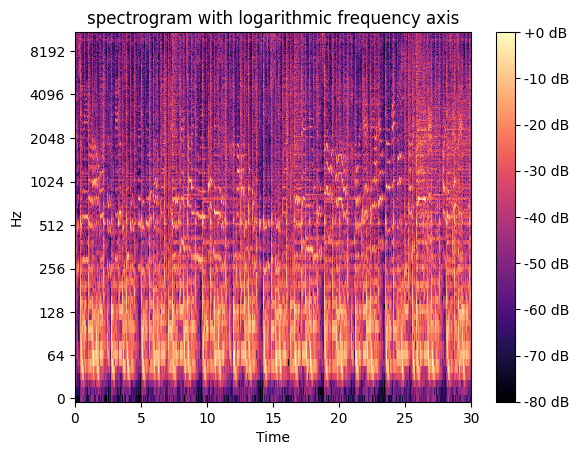

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
spectrogram_img = lb.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set(title='spectrogram with logarithmic frequency axis')
fig.colorbar(spectrogram_img, ax=ax, format="%+2.f dB")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from statistics import NormalDist

from sklearn.decomposition import PCA

from librosa import load as load_audio
from librosa import stft, amplitude_to_db
from librosa.display import specshow

from scipy.ndimage import label as label_features
from scipy.ndimage import maximum_position as extract_region_maximums

In [ ]:
def get_peaks(sg, thresh):
  flattened = np.matrix.flatten(sg)
  filtered = flattened[flattened > np.min(flattened)]

  # create a normal distribution from frequency intensities
  # then map a zscore onto each intensity value
  ndist = NormalDist(np.mean(filtered), np.std(filtered))
  zscore = np.vectorize(lambda x: ndist.zscore(x))
  zscore_matrix = zscore(sg)

  # create label matrix from frequency intensities that are
  # above threshold
  mask_matrix = zscore_matrix > thresh
  labelled_matrix, num_regions = label_features(mask_matrix)
  label_indices = np.arange(num_regions) + 1

  # for each isolated region in the mask, identify the maximum
  # value, then extract it position
  peak_positions = extract_region_maximums(
      zscore_matrix, labelled_matrix, label_indices)

  # finally, create list of peaks (time, frequency, intensity)
  peaks = [(a, b, sg[a, b]) for a, b in peak_positions]
  #The following visualisation shows the previous spectrogram plus its peaks overlaid as a scatter plot.

  return list(peaks)

In [ ]:
spec_peaks = get_peaks(S_db, 2.5)

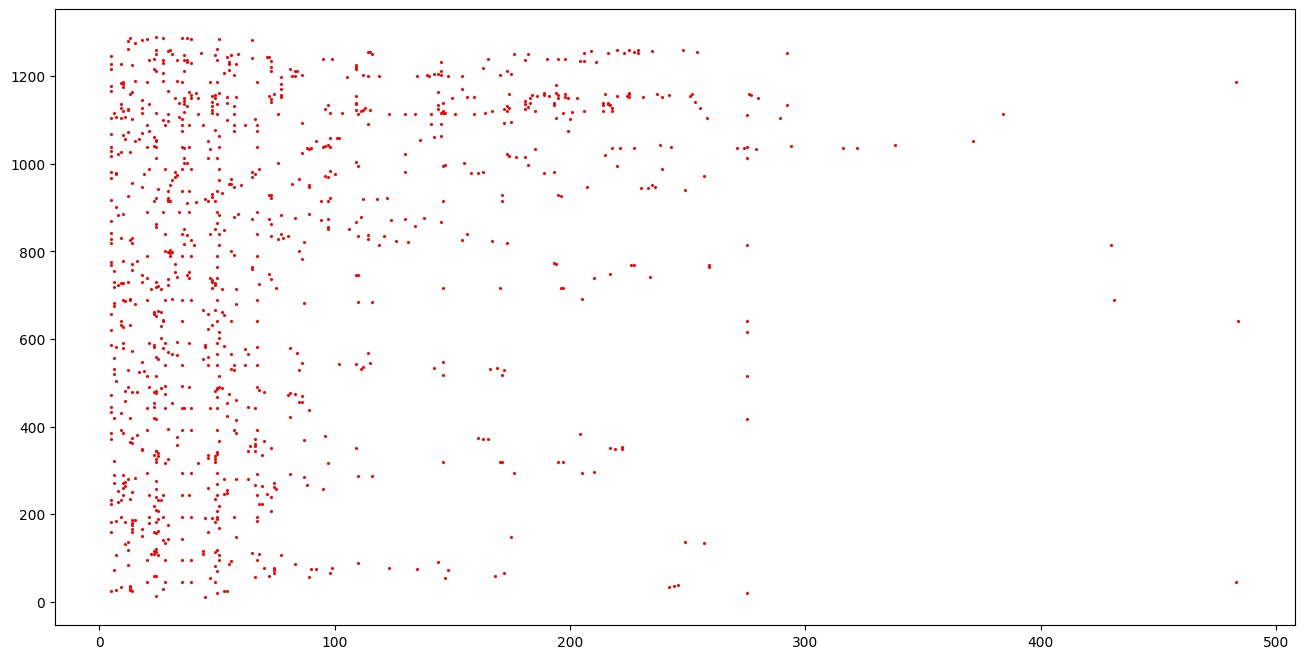

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.scatter(
    x=[p[0] for p in spec_peaks],
    y=[p[1] for p in spec_peaks],
    s=1.5,
    color="red"
)

In [ ]:
print(len(spec_peaks))

1038


In [ ]:
import pandas as pd
import hashlib
from operator import itemgetter

hash_func = lambda freq1, freq2, offset: hashlib.sha1(
    f"{str(freq1)}|{str(freq2)}|{str(offset)}".encode('utf-8')).hexdigest()[:25]

def get_hashes(specpeaks, peak_combination = 5):
    specpeaks.sort(key=itemgetter(1))

    freq_links = []
    for i in range(len(specpeaks)):
        for j in range(1, peak_combination):
            if (i + j) < len(specpeaks):

                freq1 = specpeaks[i][0]
                freq2 = specpeaks[i + j][0]
                t1 = specpeaks[i][1]
                t2 = specpeaks[i + j][1]
                t_delta = t2 - t1
                freq_links.append((freq1, t1, freq2, t2, t_delta))

    freq_links = pd.DataFrame(freq_links, columns=['freq1', 'time1', 'freq2', 'time2', 'offset'])
    freq_links = freq_links[(freq_links.offset >= 0) & (freq_links.offset < 100)].reset_index(drop=True)
    freq_links['hash'] = freq_links.apply(lambda x: hash_func(x['freq1'], x['freq2'], x['offset']), axis=1)
    return freq_links
snippet_peaks = spec_peaks[100:120]
hash_df = get_hashes(snippet_peaks)
print(hash_df.shape)
hash_df.head()

(34, 6)


,freq1,time1,freq2,time2,offset,hash
0,13,26,13,31,5,2dc170e93b25e5301df60d126
1,12,136,14,160,24,d3afd1dcdab7f17c6bd195629
2,10,590,11,686,96,859d32441b6530a20d25d6613
3,10,590,10,689,99,51e9e7ec4ba75f3ddadbdd08e
4,10,590,13,689,99,b030746a154783fa04c4a2a30


[[10 1121 12 1122]
 [10 1121 12 1126]
 [10 1121 10 1186]]


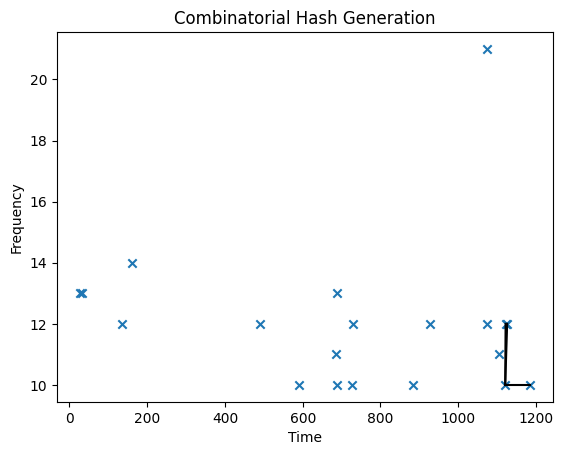

In [ ]:
rand_n = hash_df.sample()
const_arr = hash_df[(hash_df['freq1'] == rand_n['freq1'].iloc[0]) & (hash_df['time1'] == rand_n['time1'].iloc[0])]
const_arr = const_arr.values[:, 0:4]
print(const_arr)


plot_peaks = np.array(snippet_peaks)
plt.scatter(plot_peaks[:,1], plot_peaks[:,0], marker='x')
for y1, x1, y2, x2 in const_arr:
    plt.plot([x1,x2],[y1,y2],'k-')

plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Combinatorial Hash Generation')
plt.show()

In [ ]:
# Input audio sample


sample, sr = lb.load(path, sr = None)

sample_short_time = lb.stft(y)  # STFT
sample_S_db = lb.amplitude_to_db(np.abs(short_time), ref=np.max)


sample_hash_df = pd.DataFrame(columns=['freq1', 'time1', 'freq2', 'time2', 'offset', 'hash'])
sample_peaks = get_peaks(sample_S_db, 2.5)
sample_hashes = get_hashes(sample_peaks)
sample_hash_df = sample_hash_df.append(sample_hashes)

sample_hash_df = sample_hash_df.drop_duplicates(subset=['time1', 'hash'])
sample_hash_df.reset_index(drop=True, inplace=True)
print(sample_hash_df.shape)
sample_hash_df.head()

(4142, 6)


<ipython-input-66-3ed21c7f349b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_hash_df = sample_hash_df.append(sample_hashes)


,freq1,time1,freq2,time2,offset,hash
0,45,10,24,12,2,a24e4588718f4f52063274b2e
1,45,10,275,19,9,b6ed5809d0b8c7056433bfb55
2,45,10,50,20,10,63d3a531394926f5eefb1a5e6
3,45,10,5,24,14,f4bf49c5577d6dd5723e795d4
4,24,12,275,19,7,6421a04f80a6be462165f6edf


In [ ]:
dup = pd.merge(hash_df, sample_hash_df, on=['hash'])

In [ ]:
print(dup)

   freq1_x  time1_x  freq2_x  time2_x  offset_x                       hash  \
0       13       26       13       31         5  2dc170e93b25e5301df60d126   
1       11      686       10      689         3  392b3cac65a905d8947b34c93   
2       11      686       13      689         3  c6d8580d380e6e022ae79609b   
3       10      689       13      689         0  7686cbea3f9794bf784a28f74   
4       10      727       12      729         2  1721918993b8e61751ccc16c0   
5       12     1073       21     1075         2  a4435e3bab8635f60cd30c76d   

  freq1_y time1_y freq2_y time2_y offset_y  
0      13      26      13      31        5  
1      11     686      10     689        3  
2      11     686      13     689        3  
3      10     689      13     689        0  
4      10     727      12     729        2  
5      12    1073      21    1075        2  


Test

In [ ]:
# Input audio sample

test_path = ('/content/fingerprint_test_file.wav')
test, sr = lb.load(test_path, sr = None)

test_short_time = lb.stft(test)  # STFT
test_S_db = lb.amplitude_to_db(np.abs(test_short_time), ref=np.max)


test_hash_df = pd.DataFrame(columns=['freq1', 'time1', 'freq2', 'time2', 'offset', 'hash'])
test_peaks = get_peaks(test_S_db, 2.5)
test_hashes = get_hashes(test_peaks)
test_hash_df = test_hash_df.append(test_hashes)

test_hash_df = test_hash_df.drop_duplicates(subset=['time1', 'hash'])
test_hash_df.reset_index(drop=True, inplace=True)
print(test_hash_df.shape)
test_hash_df.head()

(2674, 6)


<ipython-input-46-35c48eadaf45>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_hash_df = test_hash_df.append(test_hashes)


,freq1,time1,freq2,time2,offset,hash
0,11,3,133,5,2,9c00ee8a235f8abd4d2cfa96b
1,11,3,8,9,6,64830b0db43a44e432e51748e
2,11,3,68,9,6,b22d2d6c01720cdc14ce38b14
3,11,3,113,9,6,758fac672dd25e6c3f5e3a66b
4,133,5,8,9,4,87a4c972655eaf58dd288bbec


In [ ]:
test_dup = pd.merge(hash_df, test_hash_df, on=['hash'])

In [ ]:
print(test_dup)

   freq1_x  time1_x  freq2_x  time2_x  offset_x                       hash  \
0       13       26       13       31         5  2dc170e93b25e5301df60d126   

  freq1_y time1_y freq2_y time2_y offset_y  
0      13     187      13     192        5  


In [ ]:
test2_path = ('/content/fingerprint_test_file_2.wav')
test2, sr = lb.load(test2_path, sr = None)

test2_short_time = lb.stft(test2)  # STFT
test2_S_db = lb.amplitude_to_db(np.abs(test2_short_time), ref=np.max)


test2_hash_df = pd.DataFrame(columns=['freq1', 'time1', 'freq2', 'time2', 'offset', 'hash'])
test2_peaks = get_peaks(test2_S_db, 2.5)
test2_hashes = get_hashes(test2_peaks)
test2_hash_df = test2_hash_df.append(test2_hashes)

test2_hash_df = test2_hash_df.drop_duplicates(subset=['time1', 'hash'])
test2_hash_df.reset_index(drop=True, inplace=True)
print(test2_hash_df.shape)
test2_hash_df.head()

(5006, 6)


<ipython-input-56-8ebf1d8f5f6d>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test2_hash_df = test2_hash_df.append(test2_hashes)


,freq1,time1,freq2,time2,offset,hash
0,32,1,122,1,0,c924c06d3bd532263a9bb5e99
1,32,1,256,1,0,a71fa113aa4e96070920d6f80
2,32,1,288,1,0,4efbd7ee470a1935a9453d888
3,32,1,130,2,1,a415287d152215ff8e05a9a5a
4,122,1,256,1,0,dd60bedb3ae79adab402a39b4


In [ ]:
test2_dup = pd.merge(hash_df, test2_hash_df, on=['hash'])

In [ ]:
print(test2_dup)

Empty DataFrame
Columns: [freq1_x, time1_x, freq2_x, time2_x, offset_x, hash, freq1_y, time1_y, freq2_y, time2_y, offset_y]
Index: []


In [ ]:
dup['start_time_diff'] = dup.apply(lambda x: x['time1_x'] - x['time1_x'], axis=1)

match_time = dup['start_time_diff'].value_counts().index[0]
matches_at_match_time = dup['start_time_diff'].value_counts().iloc[0]

print(f'The sample audio matches with original song at time: {match_time}')
print(f'Total match with {match_time} offset is: {matches_at_match_time}')

The sample audio matches with original song at time: 0
Total match with 0 offset is: 6


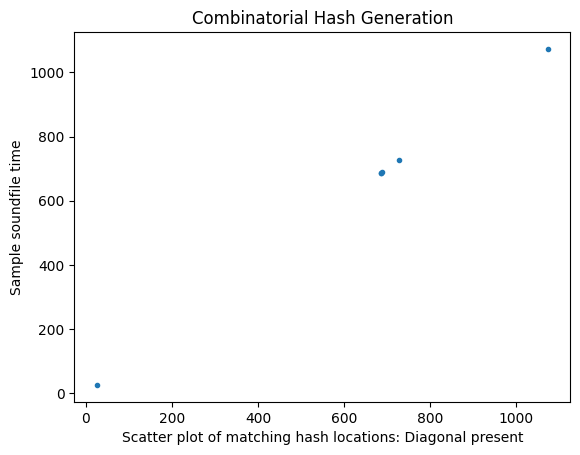

In [ ]:
align_array = dup[(dup['start_time_diff'] >= (match_time -100)) &
                       (dup['start_time_diff'] <= (match_time + 100) )][['time1_x', 'time1_x']].values

plt.scatter(align_array[:,0], align_array[:,1], marker='.')
plt.xlabel('Scatter plot of matching hash locations: Diagonal present')
plt.ylabel('Sample soundfile time')
plt.title('Combinatorial Hash Generation')
plt.show()
